In [1]:
from gwpy.timeseries import TimeSeries
from numpy import *
from gwpy.time import tconvert

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

There is a document in the DCC which give the ZPK filter for the noisemon circuit: [LIGO-T1100378](https://dcc.ligo.org/LIGO-T1100378)

There are four zeros at 0, four poles at 5 Hz, and two poles at 4000 Hz.

I just eyeballed the gain by matching the ASDs of the filtered drive signal and the noisemon.

Passing the drive signal (e.g. ETMY_L1_MASTER_LR) through this filter, you get the predicted noisemon signal. The noisemon at th L1 stage is mostly limited by noise, but you can see things like the calibration lines stick up.

Subtracting the filtered drive signal from the noisemon gives the voltage going to the coil which was not 'requested' by the drive/feedback.

In [3]:
def project_out_drive(glitch_time, dur=64, level='L1', quadrant='LR', gain=3.5e10):
    pad = 8
    gt = int(round(glitch_time))
    st=gt-dur/2
    et=gt+dur
    drive = TimeSeries.fetch('L1:SUS-ETMY_%s_MASTER_OUT_%s_DQ' % (level, quadrant),
                                st-pad, et)
    nmon = TimeSeries.fetch('L1:SUS-ETMY_%s_NOISEMON_%s_OUT_DQ' % (level, quadrant),
                                st, et)
    proj = drive.zpk([0,0,0,0], [5,5,5,5,4e3,4e3], gain).crop(st,et)
    return nmon, proj, drive.crop(st, et)

In [4]:
glitch = 1183077855.74

In [5]:
nmon, proj, drive = project_out_drive(1183077600, dur=300, quadrant='UR')

(10, 30)

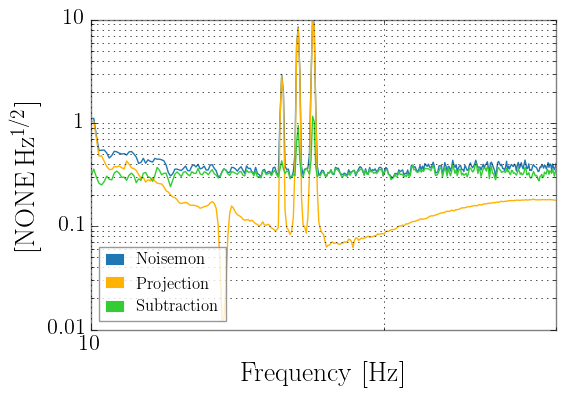

In [6]:
p1 = nmon.asd(16, 8).plot(label='Noisemon')
p1.gca().plot(proj.asd(16, 8),label='Projection')
p1.gca().plot((nmon-proj).asd(16, 8),label='Subtraction')
p1.gca().legend(loc='lower left')
p1.gca().set_ylim(1e-2,10)
p1.gca().set_xlim(10,30)

The subtraction works pretty well. I adjusted the gain until the calibration lines were as low as I could get them (because they're the strongest feature and are well above the noise). The subtraction only seems to be good to about 1 part in 10. Probably the noisemon has some extra phase or the zeros/poles are not exact. This should be good enough for our purposes.

Now we go through a few loud glitches and do this subtraction. In each case, the loud glitch in DARM, which sent a large feedback to the L1 coil, is easily visible in the noisemon. But after subtraction, there is almost nothing left in the noisemon. This means that the voltage sent to the coil (which the noisemon witnesses) is exactly what was requested of the DAC. There's no glitch coming from the coil electronics.

Note: I've also checked this for the other three quadrants. The same gain work for all of them.

In [7]:
def plot_glitch(glitch, quadrant='LR'):
    nmon, proj, drive = project_out_drive(glitch, quadrant=quadrant)
    p1 = nmon.highpass(8).crop(glitch-1, glitch+1).plot(label='Original')
    p1.gca().plot((nmon-proj).highpass(8).crop(glitch-1, glitch+1),label='Drive removed')
    p1.gca().legend()

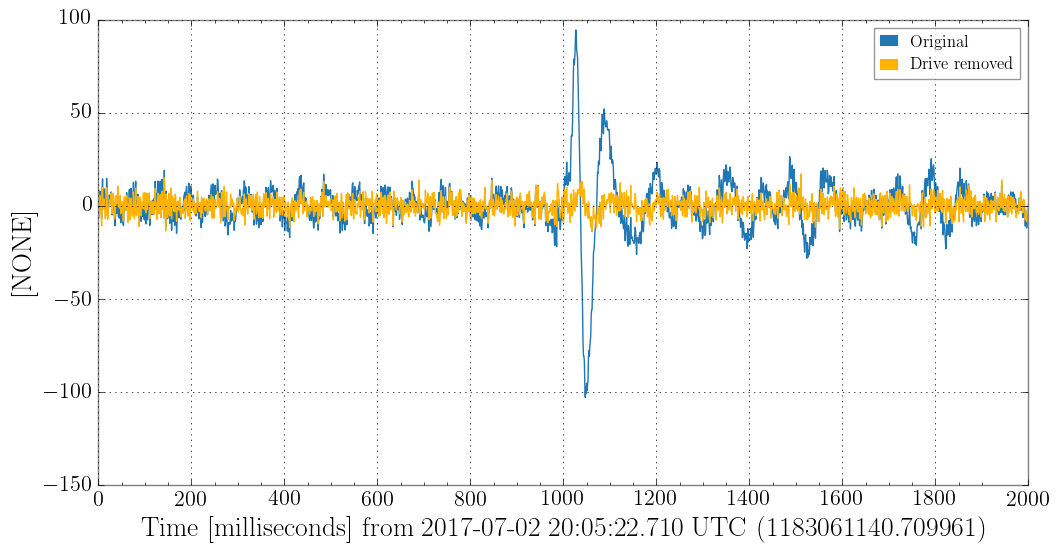

In [8]:
plot_glitch(1183061141.71)

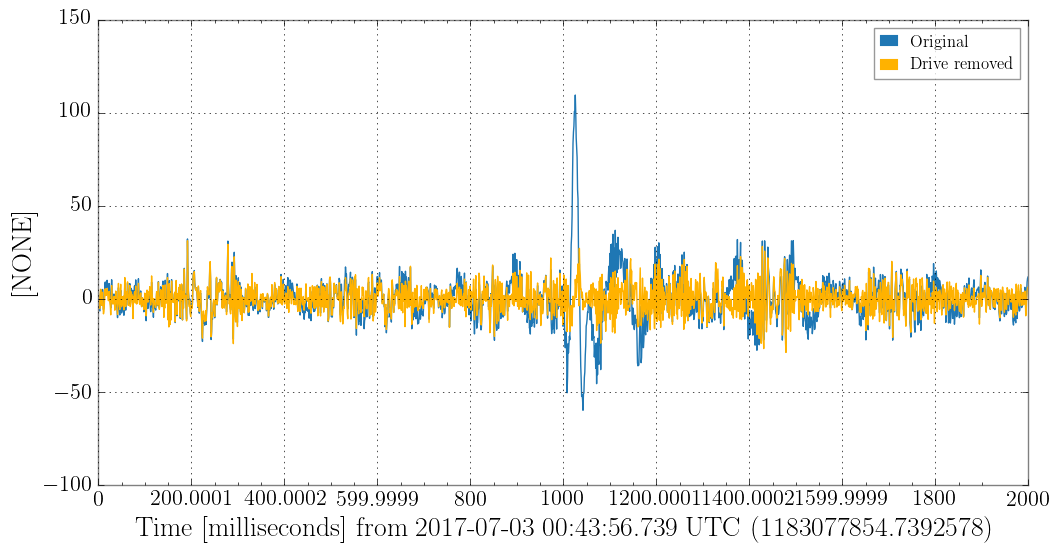

In [9]:
plot_glitch(1183077855.74)

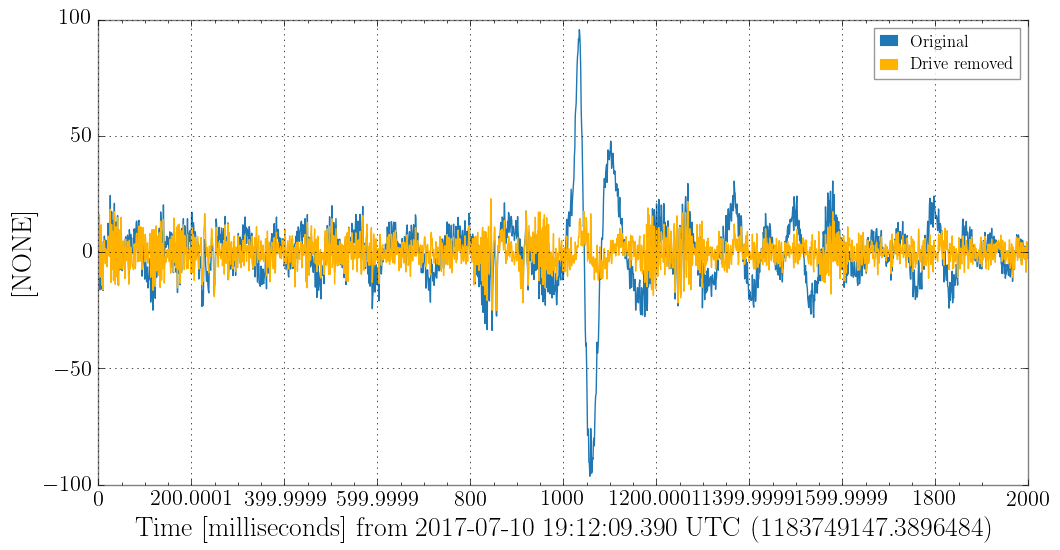

In [10]:
plot_glitch(1183749148.39)

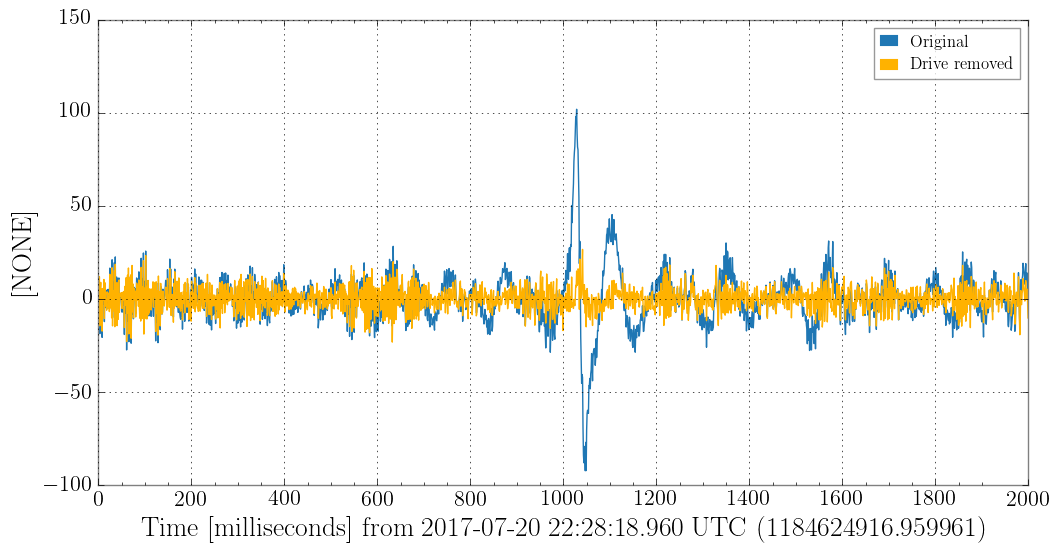

In [11]:
plot_glitch(1184624917.96)

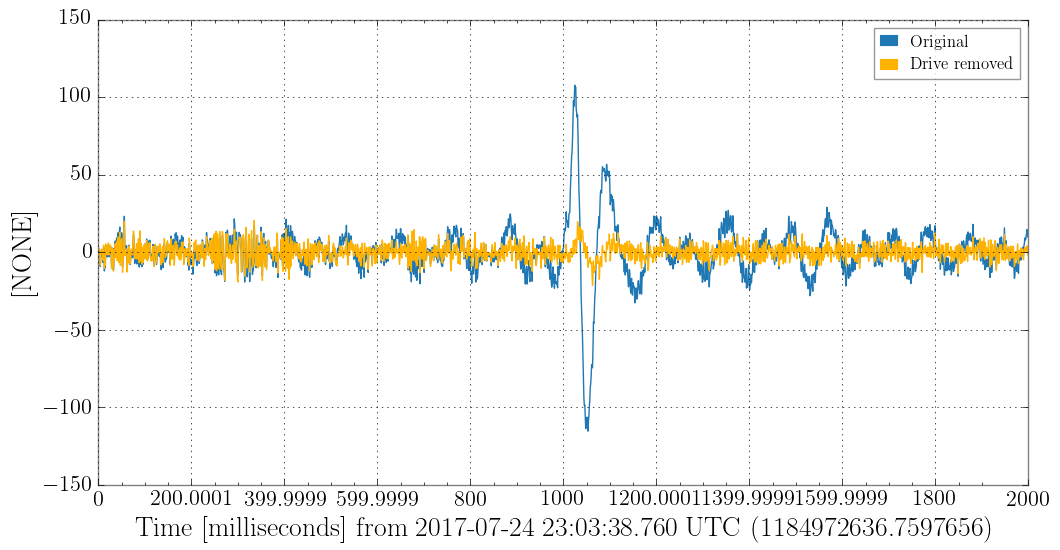

In [12]:
plot_glitch(1184972637.76)